In [16]:
import cv2
import numpy as np
import tensorflow as tf

# model
from tensorflow.keras.applications import inception_v3

# visualisation
import matplotlib.pyplot as plt
%matplotlib inline

#sklearn & skimage
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import classification_report, log_loss
from skimage.transform import rotate, AffineTransform, warp

#OS
import pickle
import os
from glob import glob

In [17]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# сохраним полезную функцию отрисовки графиков в самом начале, чтобы не искать в блокноте
def make_plots(model, name='Test', save=False):
    fig = plt.figure(figsize=(15,5))
    fig.suptitle(name, fontsize=20)

    fig.add_subplot(121)
    plt.plot(model.history.history['loss'],'b--',label='train')
    plt.plot(model.history.history['val_loss'],'g-',label='validation')
    plt.legend(loc='best')
    plt.ylabel('loss')
    x_right_limit = len(model.history.history['loss'])
    tick = int((x_right_limit+1)/10)
    if tick<1: tick=1
    plt.xticks(range(0,x_right_limit+1,tick))
    plt.grid()
    plt.xlabel('epochs')
    plt.title('Loss_vs_epoch');

    fig.add_subplot(122)
    plt.plot(model.history.history['binary_accuracy'],'b--',label='train')
    plt.plot(model.history.history['val_binary_accuracy'],'g-',label='validation')
    plt.legend(loc='best')
    plt.ylabel('accuracy')
    plt.xticks(range(0,x_right_limit+1,tick))
    plt.grid()
    plt.xlabel('epochs')
    plt.title('Accuracy_vs_epoch');
    
    if save: fig.savefig(name)

In [19]:
IMG_SIZE = (229, 229) 

## Загружаем исходные данные

In [ ]:
kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

In [20]:
train_path = glob('/content/drive/MyDrive/Colab_Notebooks/datasets/Cat_Dogs/train/train/*.jpg')
test_path = glob('/content/drive/MyDrive/Colab_Notebooks/datasets/Cat_Dogs/test/test/*.jpg')

In [21]:
# загружаем входное изображение и предобрабатываем
def load_img( path, img_size = IMG_SIZE):
    img = cv2.imread(path)[..., ::-1]
    img = cv2.resize(img, img_size )
    return inception_v3.preprocess_input(img) 


## Make augmentation

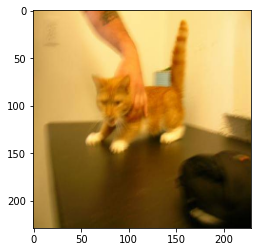

In [ ]:
# исходное фото:
img = cv2.imread(train_path[0])[..., ::-1]
img = cv2.resize(img, IMG_SIZE )
plt.imshow( img )

In [23]:
# shift function
def random_shift(image):
    dx = np.random.randint(0,40,size=1)
    dy = np.random.randint(0,40,size=1)
    tr = AffineTransform(translation=(dx,dy))
    
    return warp(image, tr, mode="symmetric").astype(np.float32)

# rotate function
def random_angle_rotate(image):
    angle = np.random.randint(-360,360,size=1)
    rotated_image = rotate( image ,angle )
    rotated_image /= np.max( np.abs( rotated_image ))
    return rotated_image.astype(np.float32)

# noise function
def random_noise(image):
    noisy_img = (image + np.random.uniform( image )) 
    noisy_img /= np.max( np.abs(noisy_img) ) 
    return noisy_img.astype(np.float32)

# box_blur function
def box_blur(image):
    box_blur_img = cv2.filter2D(image, cv2.CV_32F, np.ones((3,3))/9 )
    box_blur_img /= np.max(box_blur_img)
    
    return box_blur_img

#flip
def flip_h(image):
    return np.fliplr(image).astype(np.float32)

def flip_v(image):
    return np.flipud(image).astype(np.float32)
    

In [24]:
augment = {}
#flip
augment['flip_h'] = flip_h
augment['flip_v'] = flip_v

#shift
augment['shift'] =  random_shift

# rotate
augment['rotate'] = random_angle_rotate

#noise
augment['noise'] = random_noise

#blur
augment['blur'] = box_blur

In [28]:
def augment_picture(image, augment_count=2):
    for i in range(augment_count):
        effect = np.random.choice( list(augment.keys()) )
        #print(effect)
        image = augment[effect](image)
    return image

In [29]:
augment.keys()

dict_keys(['flip_h', 'flip_v', 'shift', 'rotate', 'noise', 'blur'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


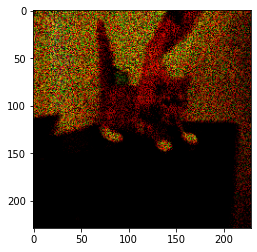

In [30]:
def load_augmented_img( path, img_size = IMG_SIZE,augment_count=4):
    img = cv2.imread(path)[..., ::-1]
    img = cv2.resize(img, img_size )
    if augment_count != 0:
        img = augment_picture(img,augment_count=augment_count)
        img = np.uint8(255 * img/ np.max(np.abs(img)))
    return inception_v3.preprocess_input(img) 

# Измененное фото:
img = load_augmented_img(train_path[0], augment_count=4)
plt.imshow( img );

## Визуализируем примеры для обучения

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

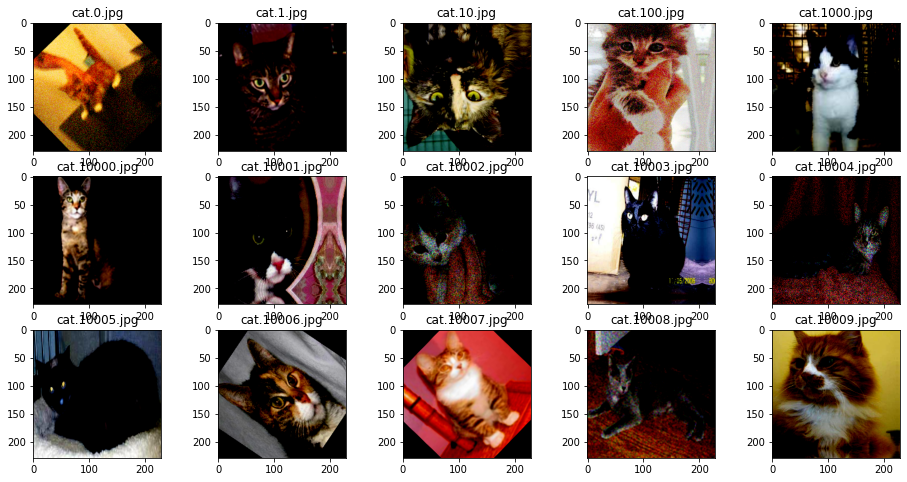

In [31]:
fig = plt.figure(figsize=(16, 8))

for i, path in enumerate( train_path[:15] , 1):
    
    subplot = fig.add_subplot(3, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    
    img = load_augmented_img(path, augment_count=np.random.randint(1,4))
    
    plt.imshow(img)

## Модель

### Создаем Итерирующие функции 

In [32]:
# функция-генератор загрузки обучающих данных с диска
def fit_generator( PATH, batch_size=10 ):
    
    while True:
        shuffled_path = np.random.choice(PATH,size=len(PATH),replace=False)

        for k in range( len(shuffled_path) // batch_size ):
                end_of_batch = (k+1)*batch_size

                # на случай если мы вышли за границу длины файлов
                if end_of_batch > len(shuffled_path):
                    end_of_batch = len(shuffled_path) - (k * batch_size)
                    
                x = np.array(  [ load_augmented_img(i, augment_count=np.random.randint(1,4) )  #augment_count=0)
                                for i in shuffled_path[k * batch_size : end_of_batch] ]  )

                y = np.array([1. if os.path.basename(i).startswith('dog') else 0.
                              for i in shuffled_path[k * batch_size : end_of_batch]])
                yield (x, y)

In [33]:
# функция-генератор загрузки Тестовых данных с диска
def test_generator( PATH, batch_size=10 ):
    for k in range( len(PATH) // batch_size ):
        end_of_batch = (k+1) * batch_size
        
        # на случай если мы вышли за границу длины файлов
        if end_of_batch > len(PATH):
            end_of_batch = len(PATH) - (k * batch_size) 
        yield np.array(  [ load_img(i) for i in PATH[k * batch_size : end_of_batch] ]  )


###  Загружаем предобученную модель  inception_v3

In [34]:
base_model = inception_v3.InceptionV3(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [35]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

### Добавляем несколько полносвязных слоев

Использую выход 86 слоя mixed2_Concatenate (всего в модели 10 mixed, самый последний mixed10_Concatenate) :

In [ ]:
#base_model.summary()

In [ ]:

x = base_model.layers[86].output  #   #mixed2 (Concatenate) 86 слой

# MaxPool + Flatten
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D((4,4))(x)
x = tf.keras.layers.Flatten()(x)
#x = tf.keras.layers.BatchNormalization()(x)

#Dense 16
x = tf.keras.layers.Dense(16)(x)
x = tf.keras.layers.Dropout(.2)(x)
x = tf.keras.layers.Activation(activation = 'relu')(x)

x = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)
x = tf.keras.layers.Activation( activation='sigmoid' )(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [ ]:
#model.summary()

### Компилируем модель и запускаем обучение

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = tf.keras.losses.binary_crossentropy,  # функция потерь binary_crossentropy (log loss
              metrics = tf.keras.metrics.binary_accuracy)

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='./saved_models/2/best_model.{epoch:03d}-loss_{val_loss:.2f}.h5',
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        mode='min') ]

In [ ]:
val_samples = 15  # 15% от всех картинок
pictures = []
target = []

valdation_path = np.random.choice(train_path, size = val_samples ,replace=False)
new_train_path = np.array( [i for i in train_path if i not in valdation_path], dtype= '<U31' )

for i in range(20):
    a = next( fit_generator( valdation_path , 5 ) )
    pictures.append(a[0])
    target.append(a[1])
    
target = np.array(target).ravel()
pictures = np.array(pictures)
pictures = pictures.reshape(-1,229,229,3)

pictures.shape,target.shape

((100, 229, 229, 3), (100,))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

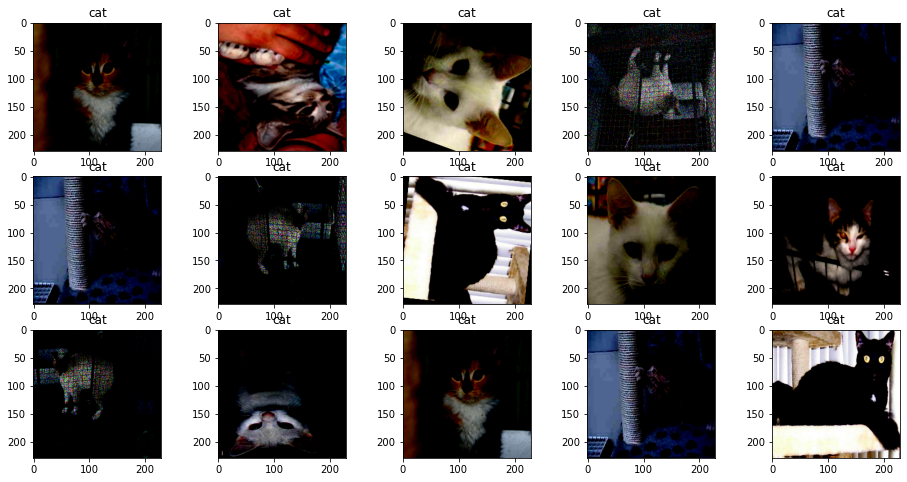

In [ ]:
# посмотрим на валидационную выборку
cat_dog = {0:'cat',1:'dog'}
validation_data = list(zip(pictures,target))

fig = plt.figure(figsize=(16, 8))

for i, (img,name) in enumerate( validation_data[:15] , 1):
    
    subplot = fig.add_subplot(3, 5, i)
    subplot.set_title('%s' % cat_dog[name] )
    
    plt.imshow(img)

In [ ]:
# запускаем процесс обучения
model.fit(fit_generator( new_train_path , batch_size=10 ),
          steps_per_epoch=10,  
          callbacks = callbacks,
          epochs=100,  
          validation_data=(pictures,target))

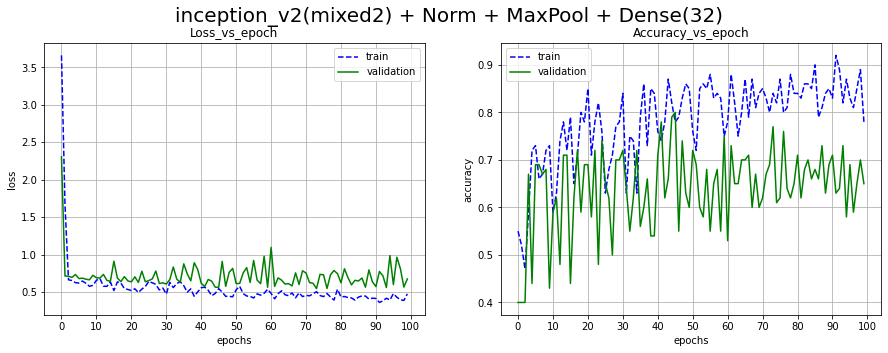

In [ ]:
make_plots(model,name='inception_v2(mixed2) + Norm + MaxPool + Dense(32)',save=True)

In [ ]:
model.save('./saved_models/cats-dogs-incep.hdf5')

А теперь __прогоним на изображениях без аугментации__:

In [ ]:
val_samples = 15  # 15% от всех картинок
pictures = []
target = []

valdation_path = np.random.choice(train_path, size = val_samples ,replace=False)
new_train_path = np.array( [i for i in train_path if i not in valdation_path], dtype= '<U31' )

for i in range(20):
    a = next( fit_generator( valdation_path , 5 ) )
    pictures.append(a[0])
    target.append(a[1])
    
target = np.array(target).ravel()
pictures = np.array(pictures)
pictures = pictures.reshape(-1,229,229,3)

pictures.shape,target.shape

((100, 229, 229, 3), (100,))

In [ ]:
# запускаем процесс обучения
model.fit(fit_generator( new_train_path , batch_size=10 ),
          steps_per_epoch=10,  
          callbacks = callbacks,
          epochs=5,  
          validation_data=(pictures,target))

Epoch 1/5
10/10 [==============================] - 15s 2s/step - loss: 0.3394 - binary_accuracy: 0.9100 - val_loss: 0.2138 - val_binary_accuracy: 1.0000
Epoch 2/5
10/10 [==============================] - 16s 2s/step - loss: 0.3338 - binary_accuracy: 0.9200 - val_loss: 0.2075 - val_binary_accuracy: 1.0000
Epoch 3/5
10/10 [==============================] - 16s 2s/step - loss: 0.3536 - binary_accuracy: 0.9000 - val_loss: 0.2121 - val_binary_accuracy: 1.0000
Epoch 4/5
10/10 [==============================] - 16s 2s/step - loss: 0.2971 - binary_accuracy: 0.9400 - val_loss: 0.2381 - val_binary_accuracy: 0.9000
Epoch 5/5
10/10 [==============================] - 17s 2s/step - loss: 0.3337 - binary_accuracy: 0.9200 - val_loss: 0.2525 - val_binary_accuracy: 0.9000


In [ ]:
model.save('./saved_models/cats-dogs-incep_wo_augmentation.hdf5')

In [ ]:
# предсказываем
test_img = np.array( [load_img(i ) for  i in test_path[:15]] )
y_pred = model.predict(test_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

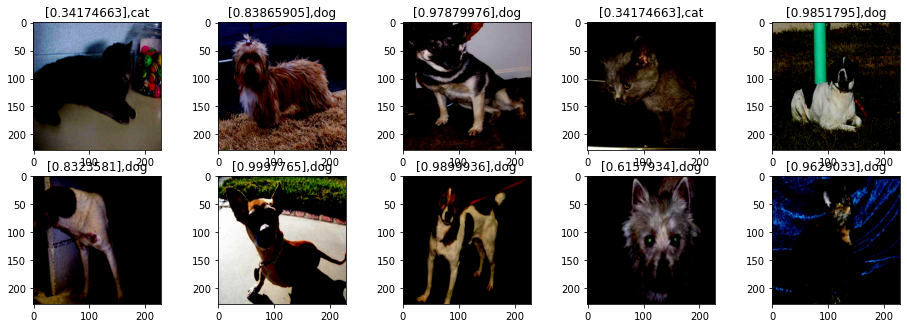

In [ ]:
# посмотрим на тестовую выборку
cat_dog = {0:'cat',1:'dog'}
validation_data = list(zip(pictures,target))

fig = plt.figure(figsize=(16, 8))

for i, (img,pred) in enumerate( zip(test_img,y_pred) , 1):
    
    subplot = fig.add_subplot(3, 5, i)
    subplot.set_title('%s,%s' % (pred, cat_dog[int(pred>.5)] )   )
    
    plt.imshow(img)

In [ ]:
# проверяем лог-лос крос энтропию
y_true = np.array([int(i>.5) for i in y_pred])
log_loss(y_true,y_pred)

0.17650602709763916

Результат кросс энтропии = 0.17. Что еще можно сделать? 

##  А если использовать последние слои предобученной модели.
Например mixed_9 [-32] слой

In [36]:
x =  base_model.layers[-32].output # mixed_9 [-32] слой
# MaxPool + Flatten
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D((4,4))(x)
x = tf.keras.layers.Flatten()(x)
#x = tf.keras.layers.BatchNormalization()(x)

#Dense 256
x = tf.keras.layers.Dense(16)(x)
x = tf.keras.layers.Dropout(.2)(x)
x = tf.keras.layers.Activation(activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)
x = tf.keras.layers.Activation( activation='sigmoid' )(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [37]:
model.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = tf.keras.losses.binary_crossentropy,  # функция потерь binary_crossentropy (log loss
              metrics = tf.keras.metrics.binary_accuracy)

In [58]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/Colab_Notebooks/saved_models/Cat_Dogs/best_model.{epoch:03d}-loss_{val_loss:.2f}.h5',
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        mode='min') ]

In [45]:
val_samples = int(len(train_path)*.15)  # 15% от всех картинок
val_batch_size = 15
pictures = []
target = []

valdation_path = np.random.choice(train_path, size = val_samples ,replace=False)
new_train_path = np.array( [i for i in train_path if i not in valdation_path], dtype= '<U82' )

for i in range( val_samples // val_batch_size ):
    a = next( fit_generator( valdation_path , val_batch_size ) )
    pictures.append(a[0])
    target.append(a[1])
    
target = np.array(target).ravel()
pictures = np.array(pictures)
pictures = pictures.reshape(-1,229,229,3)

pictures.shape,target.shape

((3750, 229, 229, 3), (3750,))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

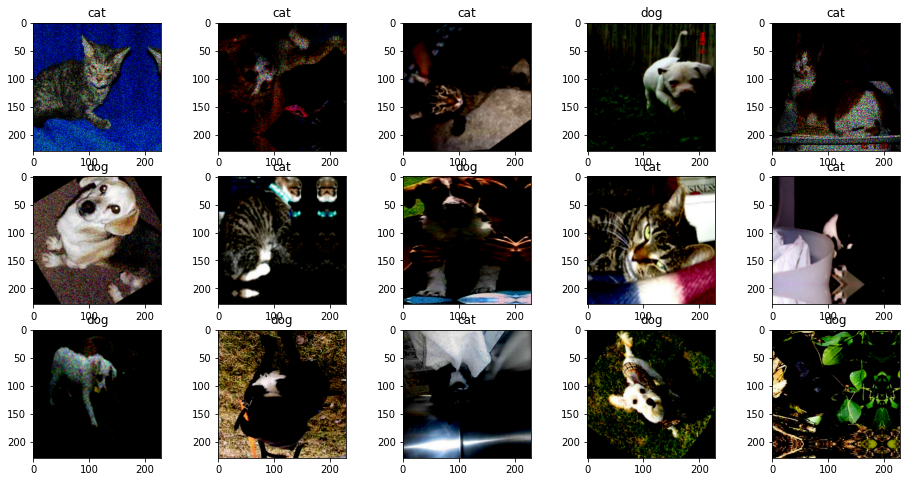

In [46]:
# посмотрим на валидационную выборку
cat_dog = {0:'cat',1:'dog'}
validation_data = list(zip(pictures,target))

fig = plt.figure(figsize=(16, 8))

for i, (img,name) in enumerate( validation_data[:15] , 1):
    
    subplot = fig.add_subplot(3, 5, i)
    subplot.set_title('%s' % cat_dog[name] )
    
    plt.imshow(img)

In [59]:
# запускаем процесс обучения
train_batch_size = 15
train_steps = len(train_path)*.75 // train_batch_size
if (len(train_path)*.75 % train_batch_size) != 0: train_steps +=1

model.fit(fit_generator( new_train_path , batch_size= train_batch_size ),
          steps_per_epoch=train_steps,  
          callbacks = callbacks,
          epochs = 10,  
          validation_data=(pictures,target))

Epoch 1/10
1250/1250 [==============================] - 432s 346ms/step - loss: 0.2031 - binary_accuracy: 0.9176 - val_loss: 0.1320 - val_binary_accuracy: 0.9451
Epoch 2/10
1250/1250 [==============================] - 432s 346ms/step - loss: 0.1886 - binary_accuracy: 0.9250 - val_loss: 0.1379 - val_binary_accuracy: 0.9461
Epoch 3/10
1250/1250 [==============================] - 390s 312ms/step - loss: 0.1879 - binary_accuracy: 0.9243 - val_loss: 0.1258 - val_binary_accuracy: 0.9515
Epoch 4/10
1250/1250 [==============================] - 381s 305ms/step - loss: 0.1887 - binary_accuracy: 0.9254 - val_loss: 0.1268 - val_binary_accuracy: 0.9517
Epoch 5/10
1250/1250 [==============================] - 386s 309ms/step - loss: 0.1857 - binary_accuracy: 0.9242 - val_loss: 0.1207 - val_binary_accuracy: 0.9565
Epoch 6/10
1250/1250 [==============================] - 398s 318ms/step - loss: 0.1759 - binary_accuracy: 0.9287 - val_loss: 0.1217 - val_binary_accuracy: 0.9541
Epoch 7/10
1250/1250 [======

In [60]:
model.save('/content/drive/MyDrive/Colab_Notebooks/saved_models/Cat_Gogs/cats-dogs-incep_mixed9.hdf5')

In [ ]:
model = tf.keras.models.load_model('./saved_models/2/cats-dogs-incep_mixed9.hdf5')

А теперь __прогоним на изображениях без аугментации:__

In [61]:
# функция-генератор загрузки обучающих данных с диска
def fit_generator( PATH, batch_size=10 ):
    
    while True:
        shuffled_path = np.random.choice(PATH,size=len(PATH),replace=False)

        for k in range( len(shuffled_path) // batch_size ):
                end_of_batch = (k+1)*batch_size

                # на случай если мы вышли за границу длины файлов
                if end_of_batch > len(shuffled_path):
                    end_of_batch = len(shuffled_path) - (k * batch_size)
                    
                x = np.array(  [ load_augmented_img(i, augment_count=0)   # without augmentation
                                for i in shuffled_path[k * batch_size : end_of_batch] ]  )

                y = np.array([1. if os.path.basename(i).startswith('dog') else 0.
                              for i in shuffled_path[k * batch_size : end_of_batch]])
                yield (x, y)

In [62]:
val_samples = int(len(train_path)*.15)  # 15% от всех картинок
val_batch_size = 15
pictures = []
target = []

valdation_path = np.random.choice(train_path, size = val_samples ,replace=False)
new_train_path = np.array( [i for i in train_path if i not in valdation_path], dtype= '<U82' )

for i in range( val_samples // val_batch_size ):
    a = next( fit_generator( valdation_path , val_batch_size ) )
    pictures.append(a[0])
    target.append(a[1])
    
target = np.array(target).ravel()
pictures = np.array(pictures)
pictures = pictures.reshape(-1,229,229,3)

pictures.shape,target.shape

((3750, 229, 229, 3), (3750,))

In [63]:
# запускаем процесс обучения
train_batch_size = 15

model.fit(fit_generator( new_train_path , batch_size= train_batch_size ),
          steps_per_epoch=10,  
          callbacks = callbacks,
          epochs = 10,  
          validation_data=(pictures,target))

Epoch 1/10
10/10 [==============================] - 25s 3s/step - loss: 0.1108 - binary_accuracy: 0.9733 - val_loss: 0.0415 - val_binary_accuracy: 0.9891
Epoch 2/10
10/10 [==============================] - 22s 2s/step - loss: 0.0838 - binary_accuracy: 0.9733 - val_loss: 0.0402 - val_binary_accuracy: 0.9899
Epoch 3/10
10/10 [==============================] - 21s 2s/step - loss: 0.1263 - binary_accuracy: 0.9467 - val_loss: 0.0409 - val_binary_accuracy: 0.9891
Epoch 4/10
10/10 [==============================] - 22s 2s/step - loss: 0.1476 - binary_accuracy: 0.9533 - val_loss: 0.0394 - val_binary_accuracy: 0.9899
Epoch 5/10
10/10 [==============================] - 22s 2s/step - loss: 0.0669 - binary_accuracy: 0.9867 - val_loss: 0.0379 - val_binary_accuracy: 0.9901
Epoch 6/10
10/10 [==============================] - 22s 2s/step - loss: 0.0525 - binary_accuracy: 0.9933 - val_loss: 0.0356 - val_binary_accuracy: 0.9907
Epoch 7/10
10/10 [==============================] - 22s 2s/step - loss: 0.08

In [64]:
model.save('/content/drive/MyDrive/Colab_Notebooks/saved_models/Cat_Gogs/cats-dogs-incep_mixed9_wo_augmentation.hdf5')

In [71]:
test_img = np.array( [load_img(i ) for  i in test_path[:15]] )
y_pred = model.predict(test_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

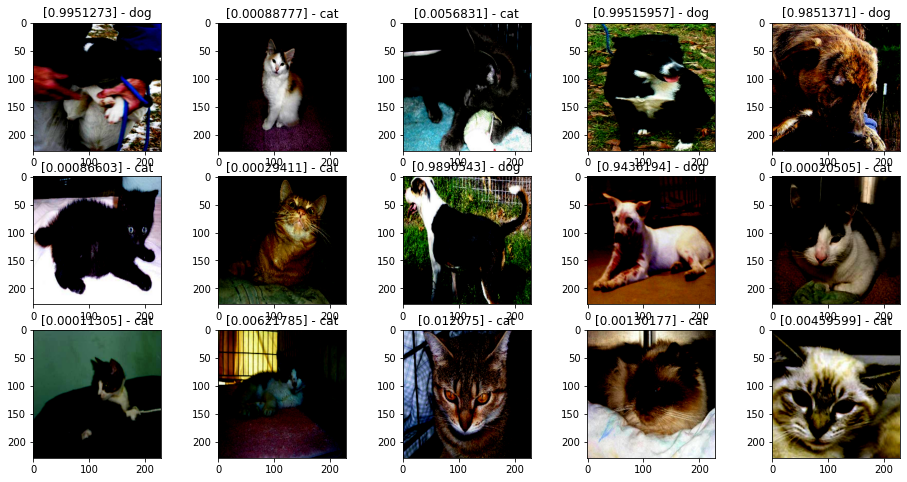

In [66]:
# посмотрим на тестовую выборку
cat_dog = {0:'cat',1:'dog'}
validation_data = list(zip(pictures,target))

fig = plt.figure(figsize=(16, 8))

for i, (img,pred) in enumerate( zip(test_img,y_pred) , 1):
    
    subplot = fig.add_subplot(3, 5, i)
    subplot.set_title('%s - %s' % (pred, cat_dog[int(pred>.5)] )   )
    
    plt.imshow(img)

In [72]:
# проверим лог лосс:
y_true = np.array([int(i>.5) for i in y_pred])
log_loss(y_true,y_pred)

0.00840738618329245

Хороший результат. Отправляем результаты:

## Готовим данные для отправки

In [67]:
test_batch_size = 10
test_steps = len(test_path) // test_batch_size
if ( len(test_path) % test_batch_size ) != 0: test_steps +=1

y_pred = model.predict(
    test_generator(test_path,batch_size=test_batch_size), steps=test_steps )

In [68]:
import re

with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_path, y_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

## Выводы:

__Было выполнено:__
- Написан код для разичных аугментаций с фото. 
- Взята за основу модель __inception_v2__ так как она самая лучшая по метрике качество/быстрота/количество слоев
- На __бошку__ поставил: Normalization + MaxPool(4,4)+ Flat + Dense(16) + Dropout(.2) + Dense(1)
- Обучена модель на датасете с изображениями , на которых было проведено __от 1 до 5__ видов __аугментации(random)__ 
- Полученная модель была еще __дообучена__ на датасете с изображеними без аугентации, но __с малым learning_rate__ (чтобы избежать переобучения)
- Результат: 
    - __validation__ dataset - __0.0084__
    - __kaggle__ dataset - __0.059__

Какие интересные наблюдения:
- Если подключиться к обученной модели ко 2ой конкатенации (из 10), то результат LogLoss = 0.176
- Если подключиться к обученной модели ко 9ой конкатенации (из 10), то результат LogLoss = 0.0084

Что можно было бы сделать для улучшения: 
- обучать не __10 эпох__(была тенденция к росту качества validation выборки), а ,например, эпох 200.(остановил из-за долгого обучения)
- добавить регуляризацию L1 на FFNN слой
- увеличить дропаут
- увеличить ширину FFNN слоя или добавить еще один FFNN слой
